# FanService-Meter: _How sexualized is your favorite manga?_

## Getting our datasets:

In [124]:
#use nhentai/random for hentai scraping
#use bato.to shonen for regular
import urllib
import requests
from bs4 import BeautifulSoup
from selenium import webdriver
import shutil
import cv2
import sys
import os.path

# some helpers
def spoofGetHtml(url):
    # Open the URL as Browser, not as python urllib
    page=urllib.request.Request(url,headers={'User-Agent': 'Mozilla/5.0'}) 
    infile=urllib.request.urlopen(page).read()
    return infile.decode('ISO-8859-1') # Read the content as string decoded with ISO-8859-1

def getImgLinksFromHTML(htmldata):
    soup = BeautifulSoup(htmldata, 'html.parser')
    images = soup.find_all('img')
    try:
        srcs = [item['src'] for item in images]
    except KeyError:
        return []
    i=0
    while i < len(srcs):
        #filter out gifs and svgs
        src = srcs[i]
        if not src.split(".")[-1] in ('jpg', 'jpeg', 'png'):
             while src in srcs: 
                    srcs.remove(src)
        i+=1
    return srcs

def getImgLinks(url):
    return getImgLinksFromHTML(spoofGetHtml(url))

def getRenderedImgLinks(url):
    fireFoxOptions = webdriver.FirefoxOptions()
    fireFoxOptions.set_headless()
    browser = webdriver.Firefox(options=fireFoxOptions)
    browser.get(url)
    html = browser.page_source
    browser.close()
    browser.quit()
    return getImgLinksFromHTML(html)
    

def downloadImgs(urls, size,  folder):
    print('downloading urls:', urls)
    for url in urls:
        filename = folder+'/'+url.split('/')[-1]
        # in case images have generic names like image.jpg
        name, type_ = filename.split('.')
        type_ = type_.split('?')[0]
        numcopys = 0
        while os.path.exists(name+"({}).".format(numcopys)+type_):
            numcopys += 1
        
        filename= name+"({}).".format(numcopys)+type_
        r = requests.get(url, stream = True)
        # Set decode_content value to True, otherwise the downloaded image file's size will be zero.
        r.raw.decode_content = True
        with open(filename, 'wb') as f:
                shutil.copyfileobj(r.raw, f)
        
        # set to grayscale and resize images so its uniform
        cvimg = cv2.imread(filename)
        cvimg = cv2.cvtColor(cv2.resize(cvimg, size), cv2.COLOR_BGR2GRAY)
        cv2.imwrite(filename, cvimg)
    

NUM_IMAGES = 750
IMG_SIZE = (300, 300)

In [123]:
# get our hentai dataset
img_count = 0
while img_count < NUM_IMAGES: #FIXME: the # of images it downloads is off but i dont rlly care
    images = getImgLinks('https://nhentai.net/random') #nhentai.net has a handy api
    img_count += len(images)
    downloadImgs(images, IMG_SIZE, 'res/hentai')
##TODO: write a loading bar instead of spamming output

In [ ]:
import random
# get our shonen dataset
# our content provider bato.to doesn't have an api so we have to write a basic crawler
htmldata = spoofGetHtml('https://bato.to/browse?genres=shounen&sort=views_a.za') #top shonen manga by views
soup = BeautifulSoup(htmldata, 'html.parser')
serieslist = soup.find(id='series-list').find_all('a', class_ = 'item-cover')
serieslinks = [link['href'] for link in serieslist]
print('pulling images from following series', serieslinks)
MAX_PER_SERIES = 100 # to diversify set #TODO: download based on how many are already in folder
total_img_count = 0
while total_img_count < NUM_IMAGES: #FIXME: the number of images it downloads is off but i dont rlly care
    htmldata = spoofGetHtml('https://bato.to' + random.choice(serieslinks))
    soup = BeautifulSoup(htmldata, 'html.parser')
    chapter_list = soup.find(class_='main').find_all('a', class_='visited chapt')
    series_img_count= 0
    while series_img_count < MAX_PER_SERIES:
        chapter_link = random.choice(chapter_list)['href']
        ch_img_links = getRenderedImgLinks('https://bato.to'+chapter_link)
        downloadImgs(ch_img_links, IMG_SIZE, 'res/manga')
        series_img_count += len(ch_img_links)
    total_img_count+=series_img_count
        

In [58]:
import os

num_skipped = 0
for folder_name in ("hentai", "manga"):
    folder_path = os.path.join("res", folder_name)
    for fname in os.listdir(folder_path):
        fpath = os.path.join(folder_path, fname)
        try:
            fobj = open(fpath, "rb")
            is_jfif = tf.compat.as_bytes("JFIF") in fobj.peek(10)
        finally:
            fobj.close()

        if not is_jfif:
            num_skipped += 1
            # Delete corrupted image
            os.remove(fpath)

print("Deleted %d images" % num_skipped)


Deleted 67 images


In [107]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

batch_size = 10 # how much my gpu vram can fit

train_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "res",
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="training",
    seed=13311,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)
val_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "res",
    labels="inferred",
    label_mode="int",
    validation_split=0.2,
    subset="validation",
    seed=13311,
    image_size=IMG_SIZE,
    batch_size=batch_size,
)

Found 1060 files belonging to 2 classes.
Using 848 files for training.
Found 1060 files belonging to 2 classes.
Using 212 files for validation.


## As you can see, lael 0 is for hentai, and 1 is for shonen

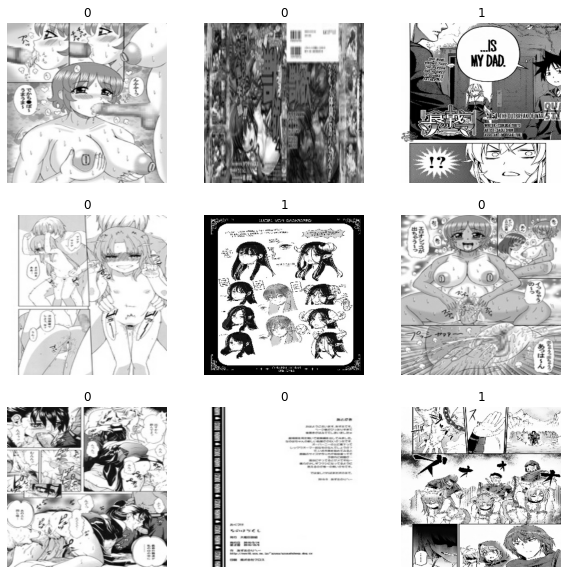

In [97]:
import matplotlib.pyplot as plt

plt.figure(figsize=(10, 10))
for images, labels in train_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(int(labels[i]))
        plt.axis("off")


## Data Augmentation helps build a robust network by performing slight modifications at random

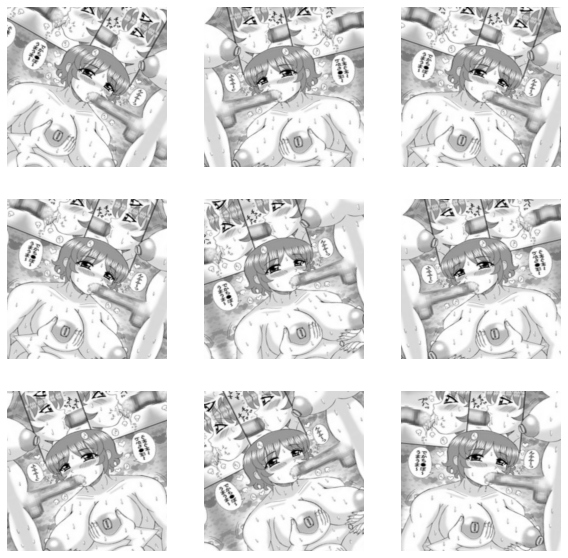

In [98]:
data_augmentation = keras.Sequential(
    [
        layers.experimental.preprocessing.RandomFlip("horizontal"),
        layers.experimental.preprocessing.RandomRotation(0.1),
    ]
)
plt.figure(figsize=(10, 10))
for images, _ in train_ds.take(1):
    for i in range(9):
        augmented_images = data_augmentation(images)
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(augmented_images[0].numpy().astype("uint8"))
        plt.axis("off")



## Create the conv net model:

In [108]:
train_ds = train_ds.prefetch(buffer_size=32)
val_ds = val_ds.prefetch(buffer_size=32)

def make_model(input_shape, num_classes):
    inputs = keras.Input(shape=input_shape)
    x = data_augmentation(inputs)
    # Entry block
    x = layers.experimental.preprocessing.Rescaling(1.0 / 255)(inputs) # scale rgb to float
    x = layers.Dropout(0.3)(x)
    x = layers.Conv2D(32, 3, strides=2, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)
    
    x = layers.Conv2D(64, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    previous_block_activation = x  # Set aside residual
    #HACK: ngl i dont rlly understand this part
    for size in [128, 256]:
        x = layers.Activation("relu")(x)
        print(x.shape)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.Activation("relu")(x)
        x = layers.SeparableConv2D(size, 3, padding="same")(x)
        x = layers.BatchNormalization()(x)

        x = layers.MaxPooling2D(3, strides=2, padding="same")(x)

        # Project residual
        residual = layers.Conv2D(size, 1, strides=2, padding="same")(
            previous_block_activation
        )
        x = layers.add([x, residual])  # Add back residual
        previous_block_activation = x  # Set aside next residual

    x = layers.SeparableConv2D(1024, 3, padding="same")(x)
    x = layers.BatchNormalization()(x)
    x = layers.Activation("relu")(x)

    x = layers.GlobalAveragePooling2D()(x)
    if num_classes == 2:
        activation = "sigmoid"
        units = 1
    else:
        activation = "softmax"
        units = num_classes

    
    outputs = layers.Dense(units, activation=activation)(x)
    return keras.Model(inputs, outputs)

model = make_model(input_shape=(IMG_SIZE[0], IMG_SIZE[1], 3), num_classes=2)
keras.utils.plot_model(model, show_shapes=True)

(None, 150, 150, 64)
(None, 75, 75, 128)
('You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) ', 'for plot_model/model_to_dot to work.')


In [109]:
model.summary()
def get_model_memory_usage(batch_size, model):
    import numpy as np
    try:
        from keras import backend as K
    except:
        from tensorflow.keras import backend as K

    shapes_mem_count = 0
    internal_model_mem_count = 0
    for l in model.layers:
        layer_type = l.__class__.__name__
        if layer_type == 'Model':
            internal_model_mem_count += get_model_memory_usage(batch_size, l)
        single_layer_mem = 1
        out_shape = l.output_shape
        if type(out_shape) is list:
            out_shape = out_shape[0]
        for s in out_shape:
            if s is None:
                continue
            single_layer_mem *= s
        shapes_mem_count += single_layer_mem

    trainable_count = np.sum([K.count_params(p) for p in model.trainable_weights])
    non_trainable_count = np.sum([K.count_params(p) for p in model.non_trainable_weights])

    number_size = 4.0
    if K.floatx() == 'float16':
        number_size = 2.0
    if K.floatx() == 'float64':
        number_size = 8.0

    total_memory = number_size * (batch_size * shapes_mem_count + trainable_count + non_trainable_count)
    gbytes = np.round(total_memory / (1024.0 ** 3), 3) + internal_model_mem_count
    return gbytes
print('memory needed',get_model_memory_usage(batch_size, model),'gb')

Model: "model_26"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_27 (InputLayer)           [(None, 300, 300, 3) 0                                            
__________________________________________________________________________________________________
rescaling_26 (Rescaling)        (None, 300, 300, 3)  0           input_27[0][0]                   
__________________________________________________________________________________________________
dropout_26 (Dropout)            (None, 300, 300, 3)  0           rescaling_26[0][0]               
__________________________________________________________________________________________________
conv2d_126 (Conv2D)             (None, 150, 150, 32) 896         dropout_26[0][0]                 
___________________________________________________________________________________________

In [42]:
import tensorflow as tf
tf.config.experimental.list_physical_devices()

[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'),
 PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]

## Actually training the model:

In [111]:
epochs = 50

callbacks = [
    keras.callbacks.ModelCheckpoint("save_at_{epoch}.h5"),
]
model.compile(
    optimizer=keras.optimizers.Adam(0.001),
    loss = "binary_crossentropy",
    metrics=["accuracy"]
)
model.fit(
    train_ds, epochs=epochs, callbacks=callbacks, validation_data=val_ds,
)


Epoch 1/50
85/85 [==============================] - 51s 569ms/step - loss: 0.2063 - accuracy: 0.9163 - val_loss: 0.6359 - val_accuracy: 0.7217
Epoch 2/50
85/85 [==============================] - 49s 572ms/step - loss: 0.1296 - accuracy: 0.9670 - val_loss: 0.6130 - val_accuracy: 0.7217
Epoch 3/50
85/85 [==============================] - 47s 552ms/step - loss: 0.1003 - accuracy: 0.9741 - val_loss: 0.6394 - val_accuracy: 0.7217
Epoch 4/50
85/85 [==============================] - 48s 565ms/step - loss: 0.1149 - accuracy: 0.9623 - val_loss: 0.7356 - val_accuracy: 0.2736
Epoch 5/50
85/85 [==============================] - 48s 568ms/step - loss: 0.0937 - accuracy: 0.9729 - val_loss: 0.6439 - val_accuracy: 0.7264
Epoch 6/50
85/85 [==============================] - 48s 564ms/step - loss: 0.0736 - accuracy: 0.9764 - val_loss: 0.9613 - val_accuracy: 0.3774
Epoch 7/50
85/85 [==============================] - 48s 564ms/step - loss: 0.0543 - accuracy: 0.9800 - val_loss: 0.3245 - val_accuracy: 0.9811

### Demo:

## __*HOLY SHIT THAT WORKED*__
### What now?
* This model can now be used as an effective metric for how sexualized a given manga is
* We can train it to scrape different series and rate them on average hentai-ness
* We can turn it into a reddit bot and have it browse r/animememes

Found 1338 files belonging to 2 classes.


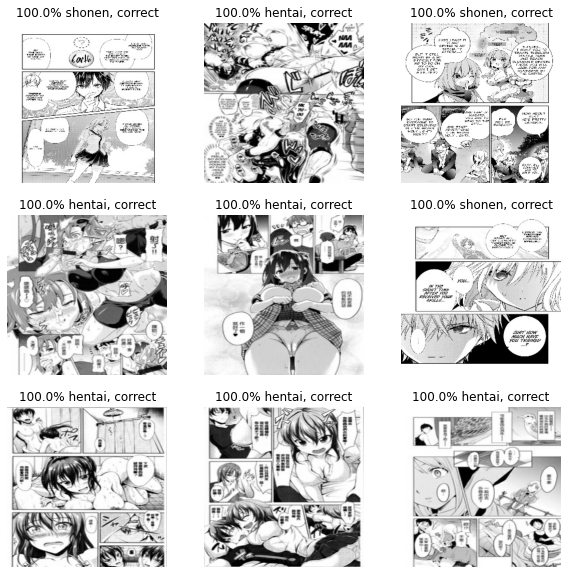

In [148]:
import random
demo_batch_size = 9
demo_ds = tf.keras.preprocessing.image_dataset_from_directory(
    "res",
    labels="inferred",
    label_mode="int",
    seed=random.randint(0, 100),  # randomly selected
    image_size=IMG_SIZE,
    batch_size=demo_batch_size,
)
plt.figure(figsize=(10, 10))
for images, labels in demo_ds.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        img_array = keras.preprocessing.image.img_to_array(images[i])
        img_array = tf.expand_dims(img_array, 0)
        predictions = model.predict(img_array)
        score = predictions[0]
        plt.title("%.1f%% %s, %s" %
                  (100 * (1 - score) if 1-score > 0.5 else 100 * score,
                   "hentai" if 1 - score > 0.5 else "shonen",
                   "wrong" if (1 - score > 0.5 and bool(labels[i])) else "correct"))
        plt.axis("off")
